# Read libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Set a Class

In [2]:
class HullWhite_grid:
    """
    HullWhiteモデルをベースとした、金利の格子をインスタンス変数に持つようなクラスを設定する。
    また、割引債価格を求める関数もメソッドに持つ
    """
    def __init__(self, T, a, sigma, phi, r_0, N):
        """
        初期化する。
        Augs
            T: 最大の時間
            a: ドリフト
        """        
        # 入力を整理
        self.T = T
        self.a = a
        self.sigma = sigma
        self.phi = phi
        self.r_0 = r_0
        self.N = N  

        # 格子の縦・横の幅を設定
        self.delta_t = self.T / self.N
        self.delta_x = self.sigma * (3 * self.delta_t) ** (1 / 2)
         
        # 格子の端点を設定
        self.I = math.ceil(6 ** (1 / 2) / (3 * self.a * self.delta_t))
        
        # 諸々の格子を作成する
        self.X_matrix = self._make_X_matrix()
        self.r_matrix = self._make_r_matrix()
        
    def calc_derivative_price(self, discount_bond_payoff = 1, coupon = False):
        """
        backwardで割引債価格を求める
        Augs
            discount_bond_payoff: 満期における割引債価格のペイオフ(指定しなければ1)
        Returns
            derivative_price: 0時点における割引債価格
        """
        derivative_matrix = np.zeros((self.I * 2 + 1, self.N))

        if coupon:
            # クーポン債
            for k in range(self.T):
                # print(self.N / self.T * (k + 1) - 1)
                derivative_matrix[:, int(self.N / self.T * (k + 1) - 1)] = coupon[k]
            
        else:
            # 割引債
            derivative_matrix[:, self.N - 1] = discount_bond_payoff

        for j in reversed(range(self.N - 1)):
            for i in range(-self.I, self.I + 1):
                if abs(i) > j:
                    # 不要な部分は計算しない
                    continue

                # 推移確率を計算
                prob = self._calc_prob(i)
                # print("i", i, prob)
                
                if abs(i) < self.I:
                    """
                    タイプA
                    """
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i - 1, j + 1] * prob["up"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i, j + 1] * prob["mid"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i + 1, j + 1] * prob["down"]
                    
                elif i == self.I:
                    """
                    タイプC
                    """ 
                    # 格子上側
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i + 2, j + 1] * prob["down_2"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i + 1, j + 1] * prob["down"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i, j + 1] * prob["mid"]

                elif i == - self.I:
                    """
                    タイプB
                    """ 
                    # 格子下側
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i - 2, j + 1] * prob["up_2"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i - 1, j + 1] * prob["up"]
                    derivative_matrix[self.I - i, j] += derivative_matrix[self.I - i, j + 1] * prob["mid"]

                # 金利を掛ける
                derivative_matrix[self.I - i, j] *= math.exp(- self.r_matrix[I - i, j] * self.delta_t) 

        self.derivative_matrix = derivative_matrix
        derivative_price = self.derivative_matrix[self.I, 0]

        return derivative_price
    
    def _make_X_matrix(self):
        """
        Xの格子を作成する
        (I * 2 + 1) × Nの配列をベースに作成
        """
        X_matrix = np.zeros((self.I * 2 + 1, self.N))
                
        for j in range(self.N):
            # j：列番号
            for i in range(-self.I, self.I + 1):
                if abs(i) > j:
                    # 不要な部分は計算しない
                    continue
                else:
                    X_matrix[self.I - i, j] = i * self.delta_x

        return X_matrix
    
    def _theta_function(self, t):
        theta = self.phi / self.a * (1 - math.exp(- self.a * t)) + self.r_0 * math.exp(- self.a * t)        
        return theta
    
    def _make_r_matrix(self):
        """
        スポットレートの格子を作る
        X_matrixをtheta(t)分シフトするだけ
        """
        r_matrix = self.X_matrix.copy()
                
        for j in range(self.N):
            # j：列番号
            r_matrix[self.I, j] += self._theta_function(self.delta_t * j)

            for i in range(1, min([j + 1, self.I + 1])):
                # i: 中心線からの距離
                # 表からはみ出ないようにしつつ、値を加算
                r_matrix[self.I - i, j] += self._theta_function(self.delta_t * j)
                r_matrix[self.I + i, j] += self._theta_function(self.delta_t * j)
        return r_matrix

    def _calc_prob(self, i):
        """
        推移確率を計算する
        """
        if abs(i) < self.I:
            """
            タイプA
            """
            # i: 中心線からの距離
            # 各点の確率を計算
            eta = (self.a * i * self.delta_x * self.delta_t) ** 2 + self.sigma ** 2 * self.delta_t
            up_prob = (eta - self.a * i * self.delta_x ** 2 * self.delta_t) / (2 * self.delta_x ** 2)
            mid_prob = 1 - eta / self.delta_x ** 2
            down_prob = (eta + self.a * i * self.delta_x ** 2 * self.delta_t) / (2 * self.delta_x ** 2)

            down_2_prob = 0
            up_2_prob = 0

        elif i == self.I:
            """
            タイプC
            """ 
            # 格子上側
            mid_prob = 7/6 + (self.a ** 2 * i ** 2 * self.delta_t ** 2 - 3 * self.a * i * self.delta_t) / 2
            down_prob = -1/3 - self.a ** 2 * i ** 2 * self.delta_t ** 2 + 2 * self.a * i * self.delta_t
            down_2_prob = 1/6 + (self.a ** 2 * i ** 2 * self.delta_t ** 2 - self.a * i * self.delta_t) / 2
            
            up_prob = 0
            up_2_prob = 0
            
        elif i == -self.I:
            """
            タイプB
            """ 
            # 格子下側
            up_2_prob = 1/6 + (self.a ** 2 * i ** 2 * self.delta_t ** 2 - self.a * abs(i) * self.delta_t) / 2
            up_prob = -1/3 - self.a ** 2 * i ** 2 * self.delta_t ** 2 + 2 * self.a * abs(i) * self.delta_t
            mid_prob = 7/6 + (self.a ** 2 * i ** 2 * self.delta_t ** 2 - 3 * self.a * abs(i) * self.delta_t) / 2

            down_prob = 0
            down_2_prob = 0
            
        return {"up_2": up_2_prob,
                "up": up_prob,
                "mid": mid_prob,
                "down": down_prob, 
                "down_2": down_2_prob}

# Set common parameters

In [3]:
T = 5
a = 0.2
sigma = 0.02
phi = 0.05
r_0 = 0.05

In [4]:
coupon = [0.05, 0.05, 0.05, 0.05, 1.05]

# Calculation

In [5]:
result_list = []

for N in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100, 125, 150, 175, 200]:
    # パラメータを作成する
    delta_t = T / N
    delta_x = sigma * (3 * delta_t) ** (1 / 2)
    I = math.ceil((6 ** (1 / 2)) / (3 * a * delta_t))
    # インスタンス作成
    instance = HullWhite_grid(T, a, sigma, phi, r_0, N)
    # 割引債価格を求める
    discount_bond_price = instance.calc_derivative_price()
    # クーポン債価格を求める
    coupon_bond_price = instance.calc_derivative_price(coupon = coupon)
    # 結果を保存
    result_list.append([N, discount_bond_price, coupon_bond_price])

In [6]:
result_df = pd.DataFrame(result_list, columns = ["N" ,"Discount Bond Price", "Coupon Bond Price"])

# Summary

収束速度が本の結果と結構違うが、理論解には収束してそう

In [7]:
# 理論解を設定（書籍から転記）
Discount_bond_theoretical_price = 0.541357
Coupon_bond_theoretical_price = 0.7264020

# 教科書記載の解を設定
result_df = pd.concat([result_df, 
                    pd.DataFrame([0.577654, 0.558917, 0.552936, 0.549994, 0.548244, 0.547084, 0.546258, 0.545640, 0.545161, 0.544778, 0.544465, 0.544205, 0.543984, 0.543769, 0.543633], columns = ["Discount Bond Price of Book"]), 
                    pd.DataFrame([0.7704655, 0.7477360, 0.7404739, 0.7368999, 0.7347736, 0.7333635, 0.7323600, 0.7316093, 0.7310266, 0.7305612, 0.7301809, 0.7298643, 0.7295967, 0.7293675, 0.7291689], columns = ["Coupon Bond Price of Book"])], axis = 1)

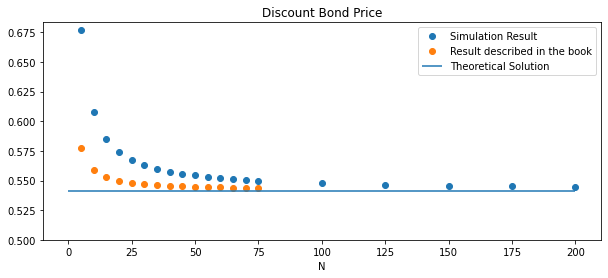

In [8]:
# シミュレーション結果を出力
plt.rcParams["figure.figsize"] = (10, 4)

plt.title("Discount Bond Price")
plt.plot(result_df["N"], result_df["Discount Bond Price"], "o", label = "Simulation Result")
plt.plot(result_df["N"], result_df["Discount Bond Price of Book"], "o", label = "Result described in the book")

plt.ylim(0.5)
plt.hlines(Discount_bond_theoretical_price, 0, 200, label = "Theoretical Solution")
plt.legend()
plt.xlabel("N")
plt.show()

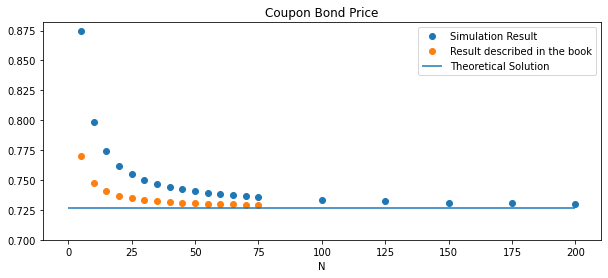

In [9]:
# シミュレーション結果を出力
plt.rcParams["figure.figsize"] = (10, 4)

plt.title("Coupon Bond Price")
plt.plot(result_df["N"], result_df["Coupon Bond Price"], "o", label = "Simulation Result")
plt.plot(result_df["N"], result_df["Coupon Bond Price of Book"], "o", label = "Result described in the book")

plt.ylim(0.7)
plt.hlines(Coupon_bond_theoretical_price, 0, 200, label = "Theoretical Solution")
plt.legend()
plt.xlabel("N")
plt.show()